In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import h5py

X = np.load('X_shred_train.npy')
print(X.shape)

nx=128
ny=128
nt=50000


(16384, 50000)


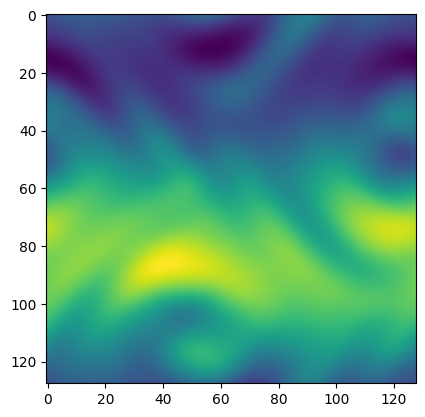

In [2]:
u = X[:,1500].reshape(nx,ny)
plt.imshow(u)


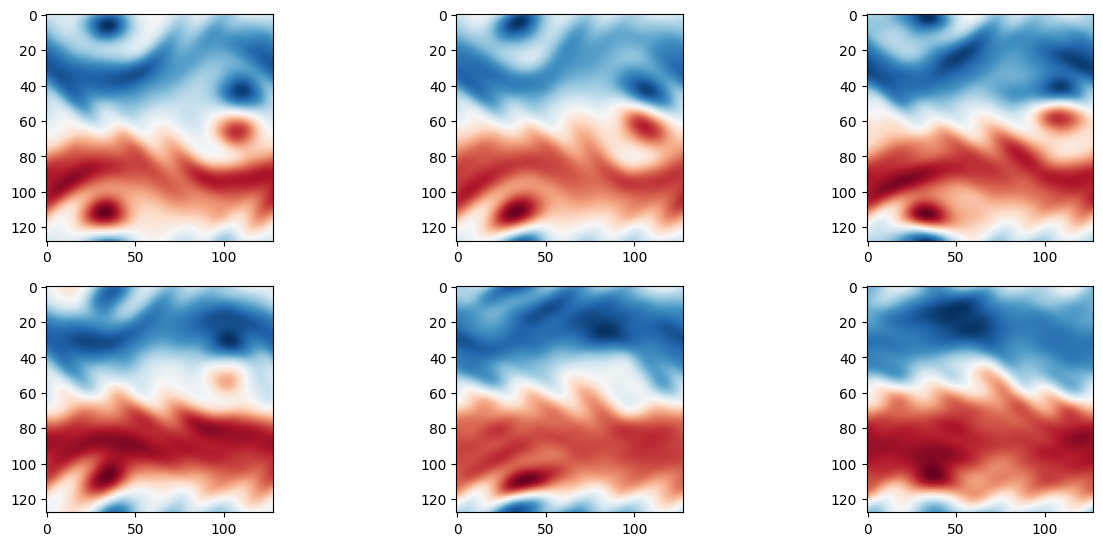

In [3]:
fig = plt.figure(figsize=(15, 10))
for k in range(6):
    u = X[:,100*k].reshape(nx,ny)
    ax = fig.add_subplot(3, 3, k+1)
    ax.imshow(u, cmap='RdBu_r')


In [4]:
from sklearn.utils.extmath import randomized_svd

r = 50
u,s,v=randomized_svd(X, n_components=r,n_iter='auto')



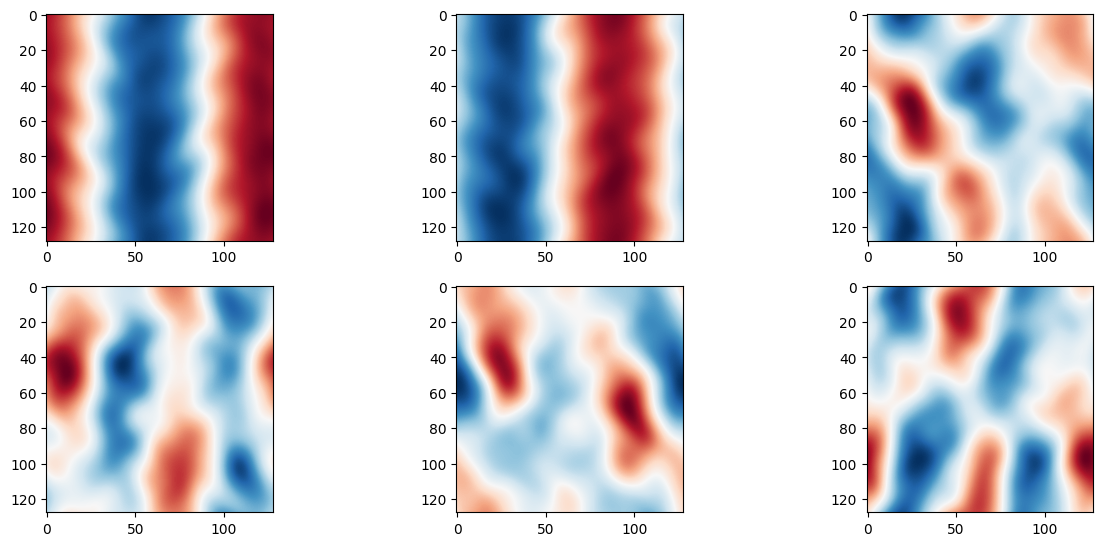

In [5]:
fig = plt.figure(figsize=(15, 10))
for k in range(6):
    Up = u[:, k].reshape((nx, ny), order='F')
    uplot = Up
    ax = fig.add_subplot(3, 3, k+1)
    ax.imshow(uplot,cmap='RdBu_r', interpolation='bilinear')

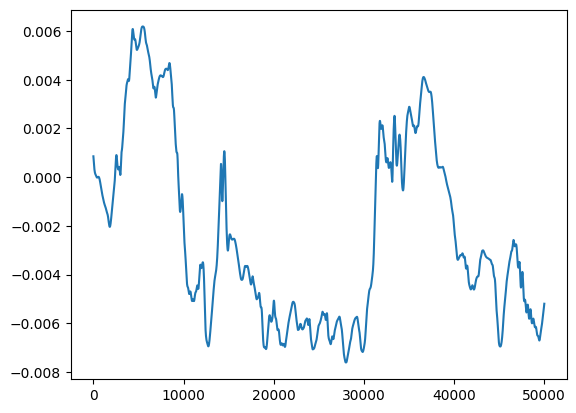

In [6]:
plt.plot(v[0,:])

<BarContainer object of 50 artists>

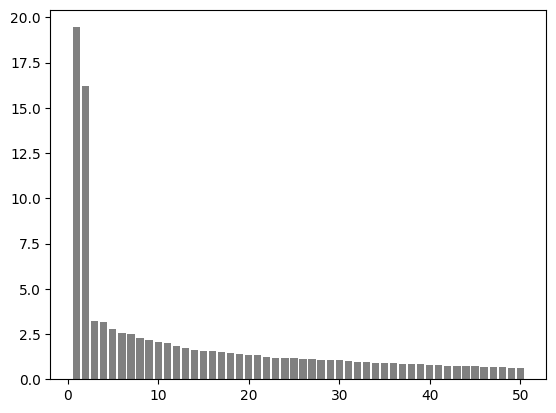

In [7]:
modesx = range(1,r+1,1)
plt.bar(modesx,100*s/np.sum(s), color='gray')


In [8]:

from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 50
n2 = nx*ny

scl_v = 100
load_X = scl_v*v.T

sensor_locations_field = np.random.choice(n2, size=num_sensors, replace=False)
sensor_locations = [0, 1, 2]

load_X = np.hstack((X[sensor_locations_field,:].T,load_X))

n = (load_X).shape[0]
m = (load_X).shape[1]
print(load_X.shape)
print(n)
print(m)
print(sensor_locations)
print(sensor_locations_field)

(50000, 53)
50000
53
[0, 1, 2]
[16200 14993 13854]


In [9]:
# TRAIN and TEST SPLIT FOR FORECASTING AND RECONSTRUCTIONS

train_indices = np.random.choice(n - lags, size=500, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]


# FORECASTING MODE
# train_indices = np.arange(0, int(n*0.85))
# valid_indices = np.arange(int(n*0.85), int(n*0.85) + 20)
# test_indices = np.arange(int(n*0.85) + 20, n - lags)



In [10]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [ ]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=3000, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.5199)
Training epoch 20
Error tensor(0.2942)
Training epoch 40
Error tensor(0.2820)
Training epoch 60
Error tensor(0.2753)
Training epoch 80
Error tensor(0.2694)
Training epoch 100
Error tensor(0.2651)
Training epoch 120
Error tensor(0.2631)
Training epoch 140
Error tensor(0.2596)
Training epoch 160
Error tensor(0.2578)
Training epoch 180
Error tensor(0.2567)
Training epoch 200
Error tensor(0.2577)
Training epoch 220
Error tensor(0.2523)
Training epoch 240
Error tensor(0.2563)
Training epoch 260
Error tensor(0.2520)


In [31]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))
print(test_recons.shape)

0.71048945
(24725, 53)


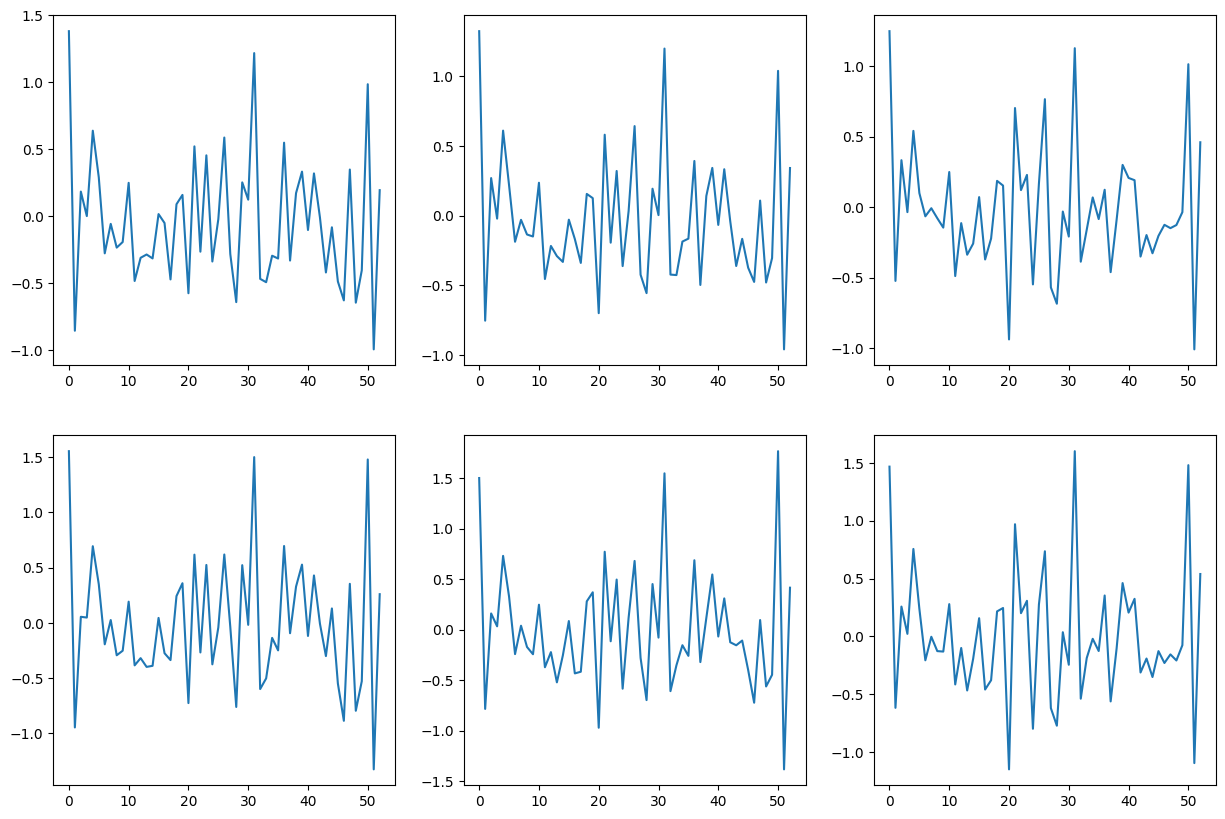

In [32]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 3, 1)
plt.plot(test_recons[10])
ax = fig.add_subplot(2, 3, 4)
plt.plot(test_ground_truth[10])
ax = fig.add_subplot(2, 3, 2)
plt.plot(test_recons[30])
ax = fig.add_subplot(2, 3, 5)
plt.plot(test_ground_truth[30])
ax = fig.add_subplot(2, 3, 3)
plt.plot(test_recons[50])
ax = fig.add_subplot(2, 3, 6)
plt.plot(test_ground_truth[50])


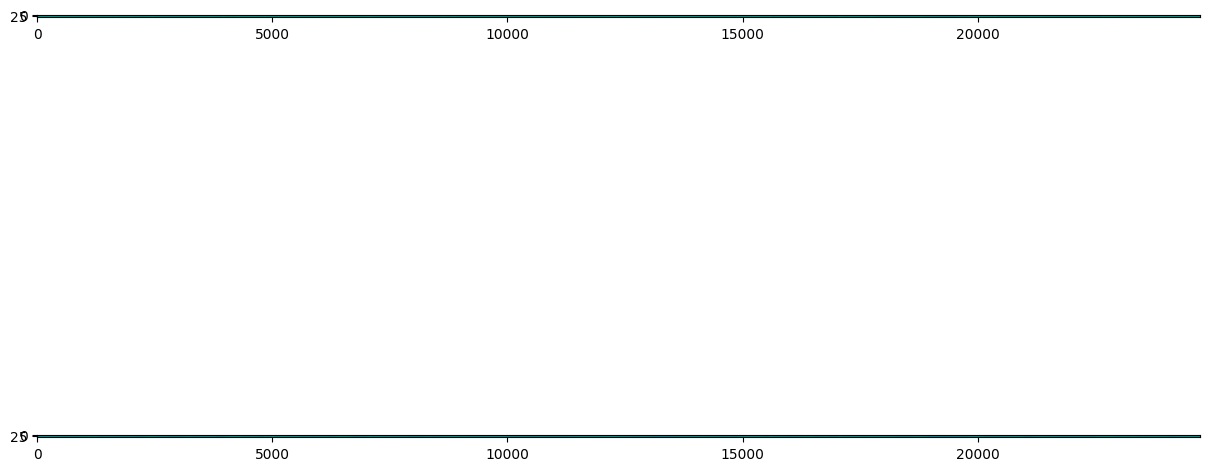

In [33]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 1, 1)
plt.imshow(test_recons[:,3:].T)
ax = fig.add_subplot(2, 1, 2)
plt.imshow(test_ground_truth[:,3:].T)

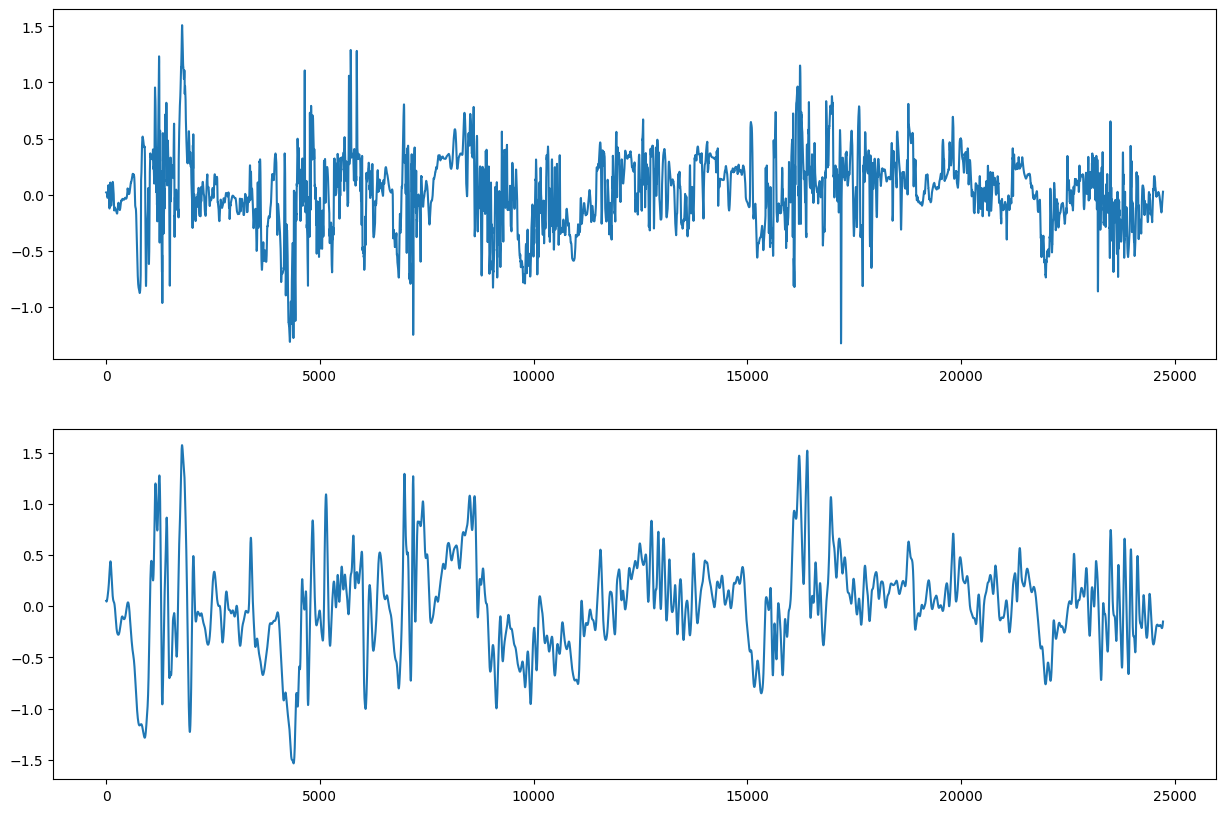

In [34]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 1, 1)
temp=test_recons[:,[15]]
plt.plot(temp)
ax = fig.add_subplot(2, 1, 2)
temp=test_ground_truth[:,[15]]
plt.plot(temp)


In [74]:
# Create a list to store individual frames
from PIL import Image
frames = []
nt2=55

vpca1 = test_ground_truth[:,3:]
vpca2 = test_recons[:,3:]
u1svd = (1/scl_c)* u @ np.diag(s) @ vpca1.T
u2svd = (1/scl_c)* u @ np.diag(s) @ vpca2.T


for j in range(nt2):
    shot1 = np.reshape(u1svd[0:nx*ny,j], (nx, ny))
    shot2 = np.reshape(u2svd[0:nx*ny,j], (nx, ny))

    #fig = plt.figure(figsize=(15, 4))
    fig = plt.figure(figsize=(30, 20))
    ax = fig.add_subplot(2, 2, 1)
    plt.imshow(shot1,cmap='RdBu_r', interpolation='bilinear')
    ax = fig.add_subplot(2, 2, 2)
    plt.imshow(shot2,cmap='RdBu_r', interpolation='bilinear')
    
    plt.title(f'Frame {j + 1}/{nt2}')
    
    # Save the plot as a temporary image file
    plt.savefig(f'movie_all/frame_{j}.png', dpi=80)  # Adjust dpi as needed
    plt.close()

    # Open and append the saved image to the list of frames
    frame = Image.open(f'movie_all/frame_{j}.png')
    frames.append(frame)

# Save the frames as a GIF
frames[0].save('animation_all.gif', save_all=True, append_images=frames[1:], loop=0, duration=100)  # Adjust duration as needed


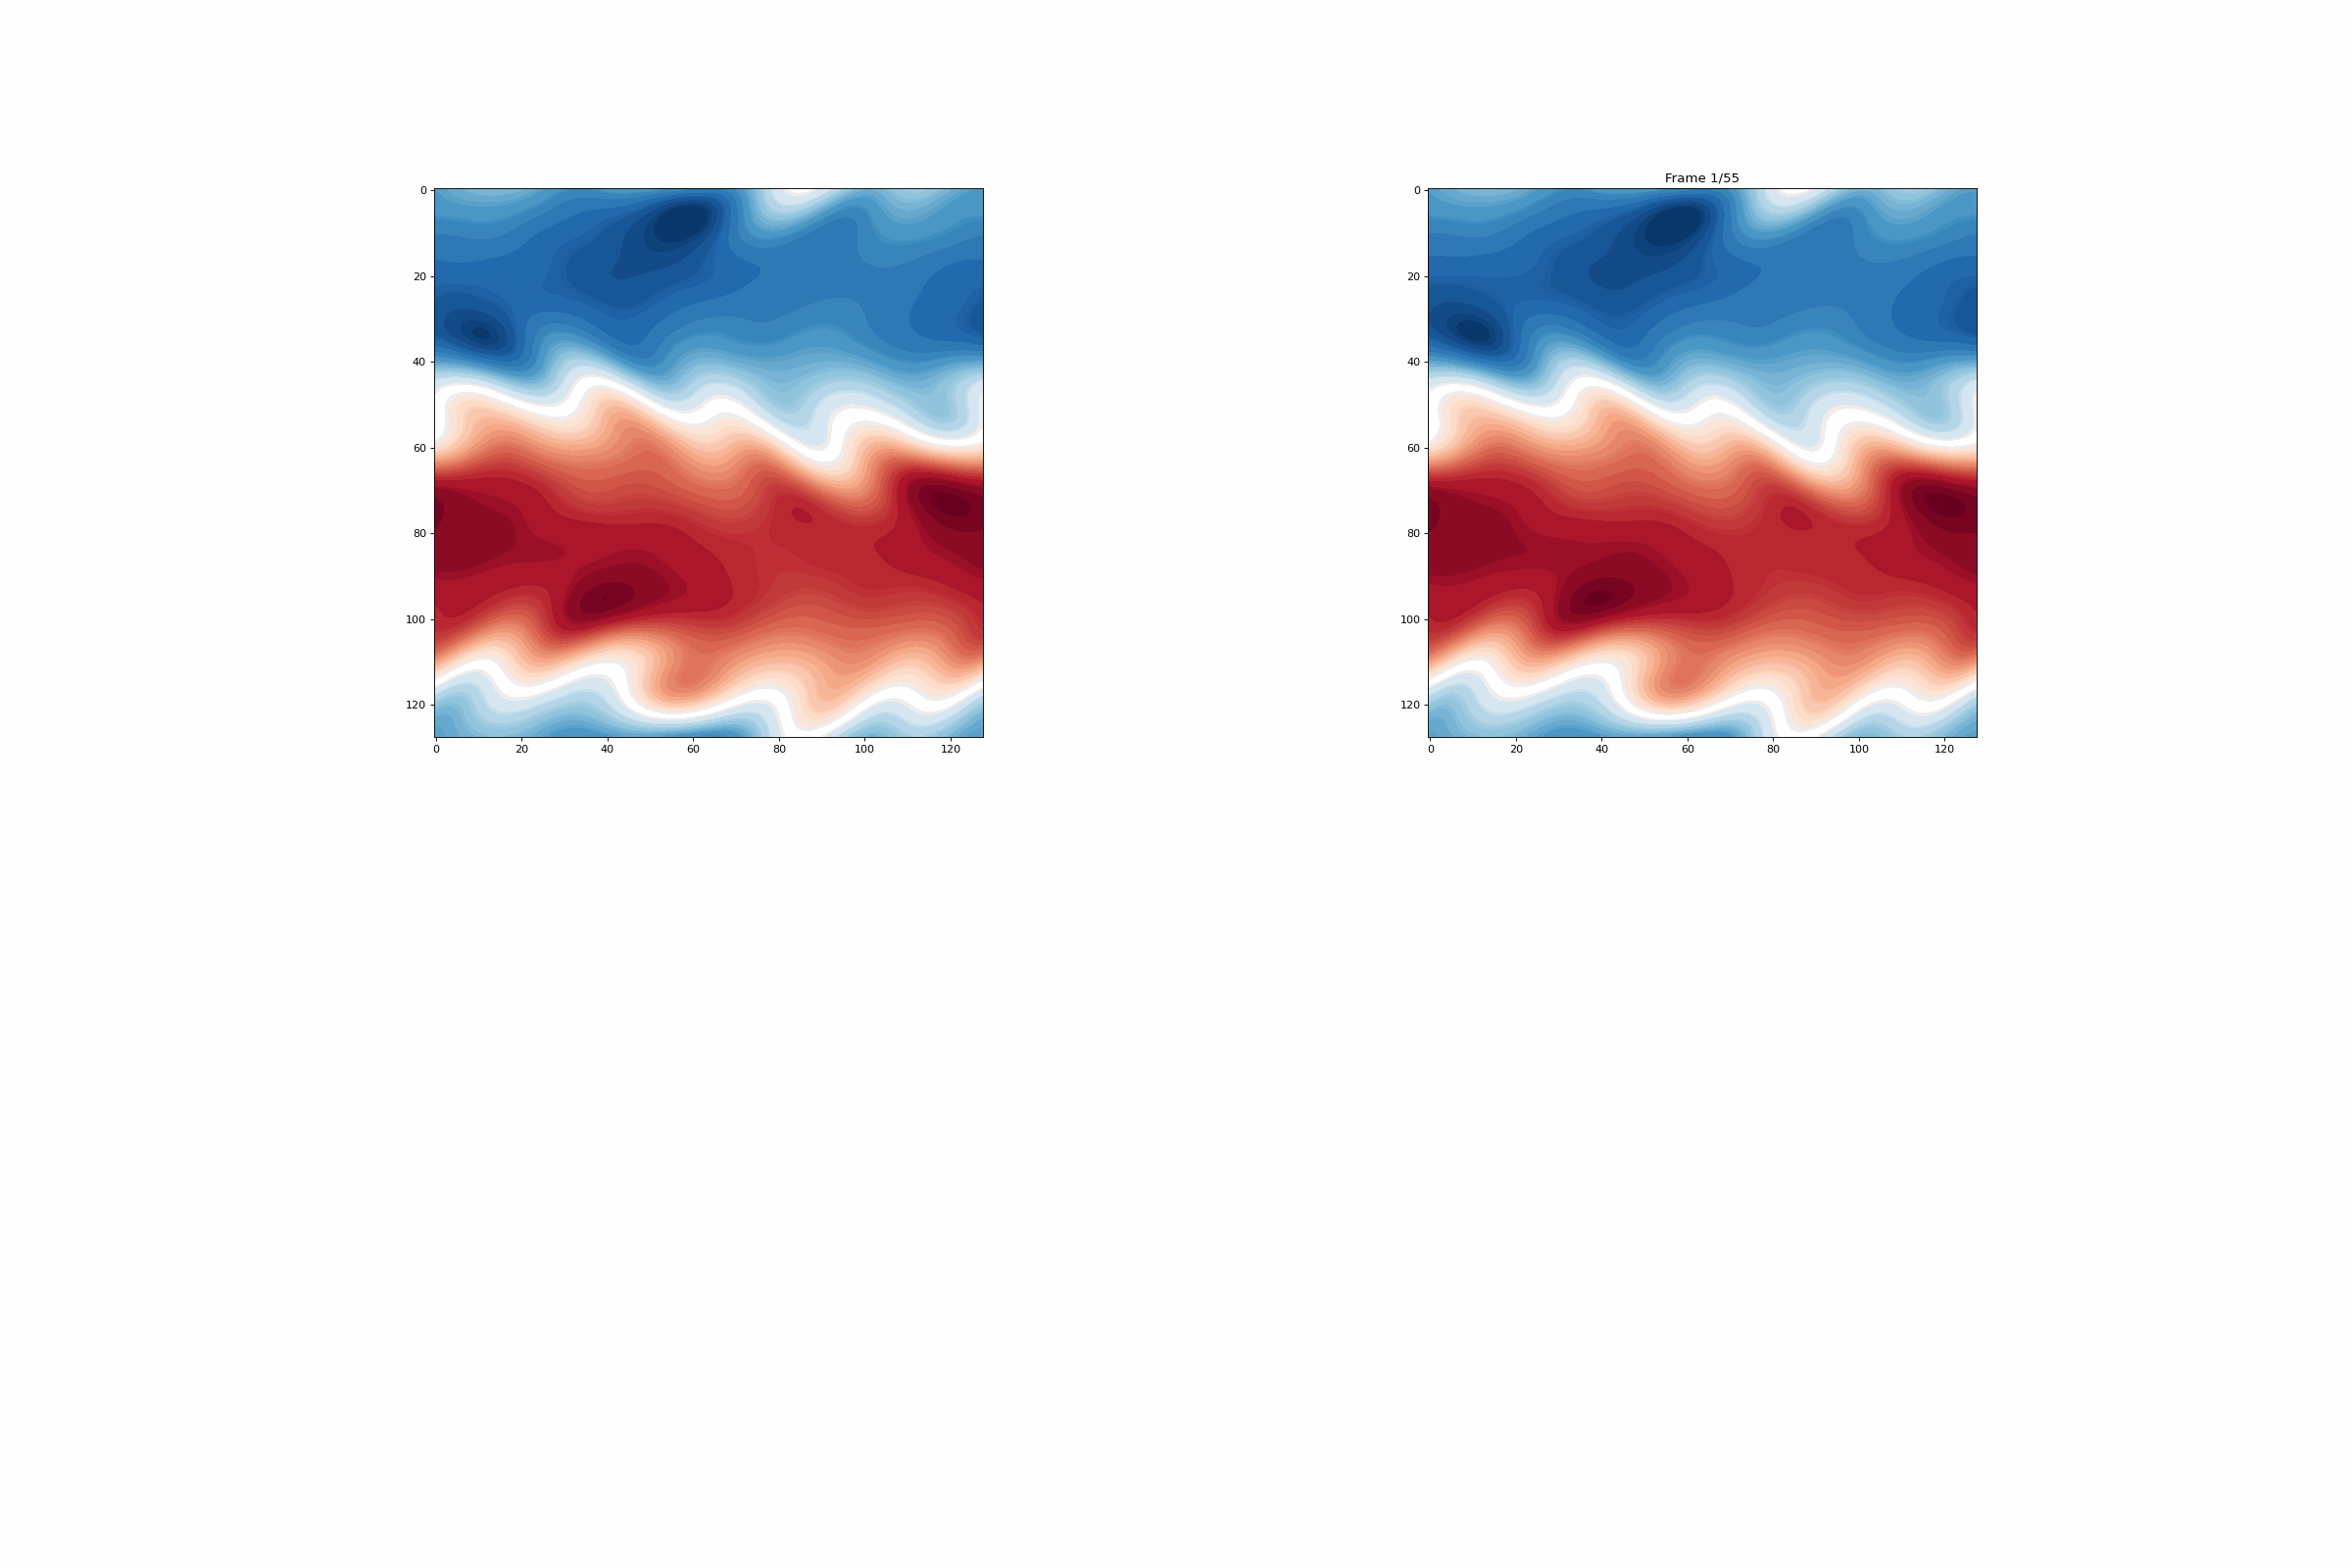

In [75]:
from IPython.display import Image

Image(filename='animation_all.gif')  # Adjust duration as needed
